1. Import library dan konfigurasi

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from IPython.display import display, Image

# Set random seed untuk reproduksibilitas
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

 2. GPU safe config

In [ ]:
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        if not tf.config.experimental.get_memory_growth(gpus[0]):
            tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU memory growth aktif.")
    else:
        print("GPU tidak terdeteksi — training akan berjalan di CPU.")
except Exception as e:
    # Aman untuk lanjutkan meskipun tidak bisa set memory growth
    print("Informasi GPU:", e)

GPU memory growth aktif.


3. Load & Pra-pemrosesan Dataset MNIST

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


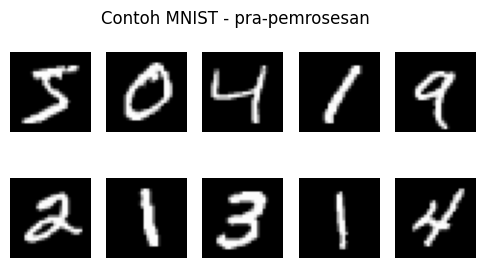

In [ ]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalisasi dan reshape agar cocok ke Conv2D (28x28x1)
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

# One-hot label
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test  = tf.keras.utils.to_categorical(y_test, 10)

# Visual cek singkat
plt.figure(figsize=(6,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.suptitle("Contoh MNIST - pra-pemrosesan")
plt.show()


4. Fungsi preprocessing tulisan tangan

In [ ]:
def preprocess_handwriting(folder):
    images, labels = [], []
    all_files = sorted(os.listdir(folder))
    for filename in all_files:
        path = os.path.join(folder, filename)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        # ambil label dari bagian sebelum underscore
        label_part = filename.split('_')[0]
        if not label_part.isdigit():
            continue
        label = int(label_part)
        # preprocessing standar: inversi warna, crop center & pad, resize 28x28, normalisasi
        # crop to bounding box then center
        _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresh = 255 - thresh  # foreground = white
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            c = max(contours, key=cv2.contourArea)
            x,y,w,h = cv2.boundingRect(c)
            roi = thresh[y:y+h, x:x+w]
        else:
            roi = thresh
        # keep aspect ratio, resize to fit in 20x20 then pad to 28x28 (MNIST style)
        h, w = roi.shape
        if h > 0 and w > 0:
            scale = 20.0 / max(h,w)
            new_h, new_w = int(h*scale), int(w*scale)
            roi_resized = cv2.resize(roi, (new_w, new_h), interpolation=cv2.INTER_AREA)
        else:
            roi_resized = cv2.resize(thresh, (20,20), interpolation=cv2.INTER_AREA)
        # pad to 28x28
        top = (28 - roi_resized.shape[0]) // 2
        bottom = 28 - roi_resized.shape[0] - top
        left = (28 - roi_resized.shape[1]) // 2
        right = 28 - roi_resized.shape[1] - left
        roi_padded = cv2.copyMakeBorder(roi_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
        # normalize to 0-1 float
        img_final = roi_padded.astype('float32') / 255.0
        images.append(img_final.reshape(28,28,1))
        labels.append(label)
    return np.array(images), np.array(labels)


5. Model A – CNN dari Nol

In [ ]:

def build_modelA():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', input_shape=(28,28,1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

modelA = build_modelA()
modelA.compile(optimizer=optimizers.Adam(0.0008), loss='categorical_crossentropy', metrics=['accuracy'])
modelA.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,378 (774.91 KB)

 Trainable params: 197,930 (773.16 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.08,
                             height_shift_range=0.08,
                             zoom_range=0.08)

BATCH_SIZE = 64
EPOCHS_A = 20

train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, seed=SEED)
# validasi tetap menggunakan validation_split via numpy slicing for simplicity
val_split = 0.2
val_count = int(len(x_train) * val_split)
x_val = x_train[:val_count]
y_val = y_train[:val_count]
x_tr  = x_train[val_count:]
y_tr  = y_train[val_count:]

historyA = modelA.fit(train_gen,
                      steps_per_epoch = len(x_tr)//BATCH_SIZE,
                      epochs = EPOCHS_A,
                      validation_data = (x_val, y_val),
                      callbacks=[callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)])
# simpan model
modelA.save('/content/modelA_best.keras')


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.7111 - loss: 0.9440 - val_accuracy: 0.9720 - val_loss: 0.0873 - learning_rate: 8.0000e-04
Epoch 2/20
188/750 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9451 - loss: 0.1801

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9466 - loss: 0.1775 - val_accuracy: 0.9756 - val_loss: 0.0770 - learning_rate: 8.0000e-04
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9533 - loss: 0.1520 - val_accuracy: 0.9877 - val_loss: 0.0395 - learning_rate: 8.0000e-04
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9656 - loss: 0.1137 - val_accuracy: 0.9880 - val_loss: 0.0374 - learning_rate: 8.0000e-04
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9708 - loss: 0.0993 - val_accuracy: 0.9915 - val_loss: 0.0266 - learning_rate: 8.0000e-04
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9748 - loss: 0.0845 - val_accuracy: 0.9897 - val_loss: 0.0318 - learning_rate: 8.0000e-04
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9750 - loss: 0.0815 - val_accuracy: 0.9908 - val_loss: 0.0285 - learning_rate: 8.0000e-04
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.976

5. Visualisasi Arsitektur dan History Training Model A

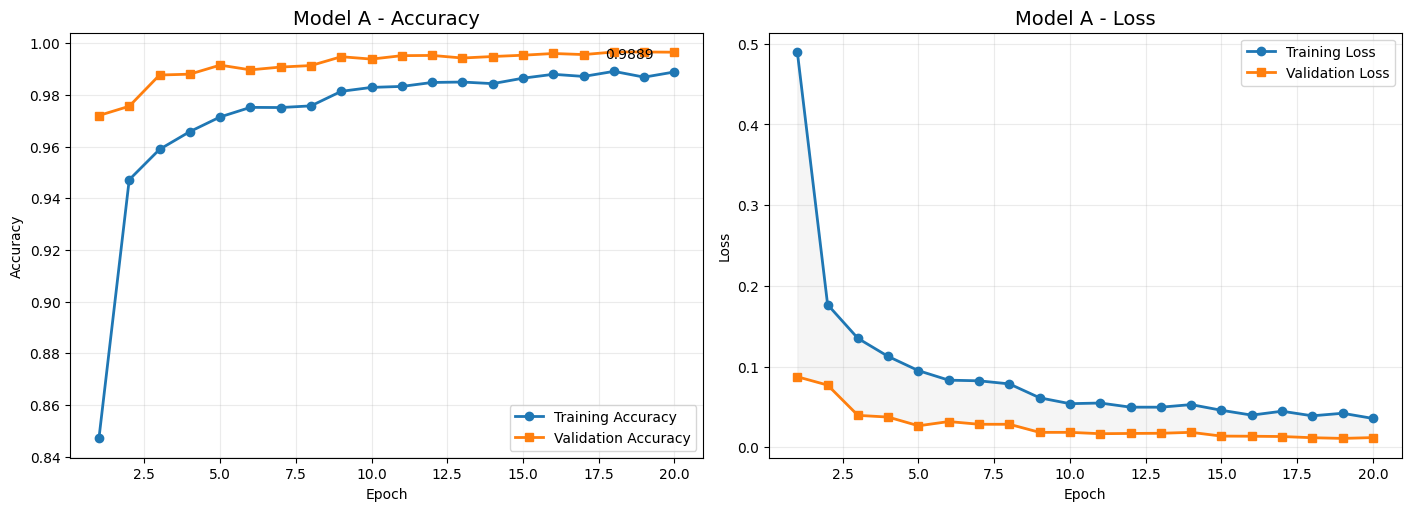

In [ ]:

def plot_training_history(history, title_prefix="Model"):
    # enhanced, readable plot: acc & loss side by side, with annotations
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(14,5), constrained_layout=True)

    # Accuracy subplot
    ax1 = plt.subplot(1,2,1)
    ax1.plot(epochs, acc, marker='o', linewidth=2, label='Training Accuracy')
    if val_acc is not None:
        ax1.plot(epochs, val_acc, marker='s', linewidth=2, label='Validation Accuracy')
    ax1.set_title(f'{title_prefix} - Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.grid(alpha=0.25)
    ax1.legend()
    # annotate final value
    ax1.annotate(f"{acc[-1]:.4f}", xy=(epochs[-1], acc[-1]), xytext=(-50,10), textcoords='offset points')

    # Loss subplot
    ax2 = plt.subplot(1,2,2)
    ax2.plot(epochs, loss, marker='o', linewidth=2, label='Training Loss')
    if val_loss is not None:
        ax2.plot(epochs, val_loss, marker='s', linewidth=2, label='Validation Loss')
    ax2.set_title(f'{title_prefix} - Loss', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(alpha=0.25)
    ax2.legend()
    # fill between to show gap
    if val_loss is not None:
        ax2.fill_between(epochs, loss, val_loss, color='gray', alpha=0.08)
    plt.show()

# plot Model A
plot_training_history(historyA, title_prefix="Model A")


6. Evaluasi Model A dengan Tulisan Tangan Sendiri

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
Akurasi Model A terhadap tulisan tangan: 96.67%



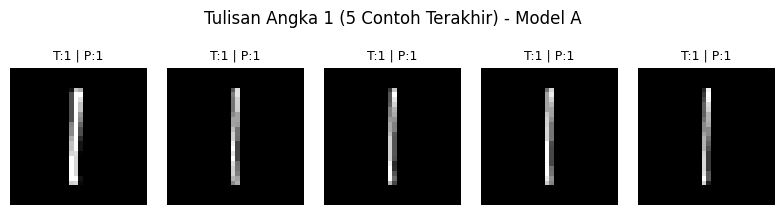

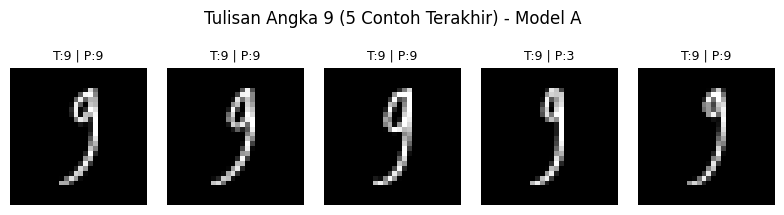

In [ ]:

images, labels = preprocess_handwriting('/content/tulisan_tangan')
if len(images) == 0:
    print("Folder tulisan tangan kosong atau nama file tidak sesuai format <digit>_<id>.jpeg")
else:
    pred_A = np.argmax(modelA.predict(images), axis=1)
    acc_A = np.mean(pred_A == labels)
    print(f"Akurasi Model A terhadap tulisan tangan: {acc_A*100:.2f}%\n")

    unique_digits = sorted(list(set(labels)))
    sample_size = 5
    for digit in unique_digits:
        idxs = np.where(labels == digit)[0]
        if len(idxs) == 0: continue
        selected = idxs[-sample_size:] if len(idxs) >= sample_size else idxs
        plt.figure(figsize=(8,2))
        plt.suptitle(f"Tulisan Angka {digit} (5 Contoh Terakhir) - Model A", y=1.05)
        for i, idx in enumerate(selected):
            plt.subplot(1, len(selected), i+1)
            plt.imshow(images[idx].reshape(28,28), cmap='gray')
            plt.title(f"T:{labels[idx]} | P:{pred_A[idx]}", fontsize=9)
            plt.axis('off')
        plt.tight_layout()
        plt.show()


7. Model B – Transfer Learning

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, callbacks
import tensorflow as tf

# - MNIST memiliki gambar grayscale 28x28, sedangkan EfficientNet butuh input RGB (3 channel).
# - Maka setiap gambar dikonversi ke RGB dan di-resize ke 96x96.
# - Pipeline dibuat dengan tf.data agar loading batch lebih efisien dan mencegah OOM.

IMG_SIZE = 96
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Dataset pipeline (tetap sama)
def preprocess_for_transfer(image, label):
    img_rgb = tf.image.grayscale_to_rgb(image)
    img_resized = tf.image.resize(img_rgb, [IMG_SIZE, IMG_SIZE])
    return img_resized, label

train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .shuffle(10000)
            .map(lambda x,y:(tf.cast(x,tf.float32), y), num_parallel_calls=AUTOTUNE)
            .map(preprocess_for_transfer, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
          .map(lambda x,y:(tf.cast(x,tf.float32), y), num_parallel_calls=AUTOTUNE)
          .map(preprocess_for_transfer, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE))

# - EfficientNetB0 dipakai karena ringan dan sudah terlatih di ImageNet
# - Lapisan bawah dibekukan untuk menjaga fitur dasar seperti tepi, bentuk, tekstur
# - Hanya lapisan atas (10 layer terakhir) yang di-train ulang agar adaptif ke digit MNIST
# - Tambahkan BatchNormalization & Dropout untuk stabilitas dan regularisasi

base = EfficientNetB0(weights='imagenet', include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
# Bekukan hampir semua layer kecuali 10 terakhir untuk fine-tuning ringan
for layer in base.layers[:-10]:
    layer.trainable = False

# Head jaringan (fully connected)
x = GlobalAveragePooling2D()(base.output)         # rata-rata spasial dari feature map
x = Dense(256, activation='relu')(x)              # dense layer utama
x = BatchNormalization()(x)                       # stabilkan distribusi aktivasi
x = Dropout(0.6)(x)                               # cegah overfitting berat
out = Dense(10, activation='softmax', dtype='float32')(x)  # output 10 kelas digit

modelB_stable = Model(inputs=base.input, outputs=out)


In [ ]:
# - Learning rate diturunkan agar training lebih halus (3e-5)
# - Adam dipilih karena adaptif terhadap gradien kecil di model besar
optimizer = optimizers.Adam(learning_rate=3e-5)
modelB_stable.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# - EarlyStopping: hentikan training otomatis jika val_loss tidak membaik (mencegah overtraining)
# - ReduceLROnPlateau: turunkan LR bila val_loss stagnan, supaya model bisa keluar dari local minima
# - ModelCheckpoint: simpan model dengan val_loss terbaik selama training
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

lr_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

checkpoint = callbacks.ModelCheckpoint(
    filepath='/content/modelB_stable_best.keras',
    monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
# - Epoch lebih banyak (25) karena LR kecil
# - Training kini lebih stabil, meski waktu sedikit lebih lama

EPOCHS_B_STABLE = 25
historyB_stable = modelB_stable.fit(
    train_ds,
    epochs=EPOCHS_B_STABLE,
    validation_data=val_ds,
    callbacks=[early_stop, lr_plateau, checkpoint],
    verbose=1
)

modelB_stable.save('/content/modelB_stable_final.keras')

Epoch 1/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1432 - loss: 3.0144
Epoch 1: val_loss improved from inf to 2.02224, saving model to /content/modelB_stable_best.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 73s 48ms/step - accuracy: 0.1433 - loss: 3.0141 - val_accuracy: 0.1705 - val_loss: 2.0222 - learning_rate: 3.0000e-05
Epoch 2/25
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3415 - loss: 2.0871
Epoch 2: val_loss improved from 2.02224 to 1.57411, saving model to /content/modelB_stable_best.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.3417 - loss: 2.0866 - val_accuracy: 0.4635 - val_loss: 1.5741 - learning_rate: 3.0000e-05
Epoch 3/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5080 - loss: 1.5180
Epoch 3: val_loss did not improve from 1.57411
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.5081 - loss: 1.5179 - val_accuracy: 0.3048 - val_loss: 1.9180 - learning_rate: 3.0000e-05
Epoch 4/25
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/ste

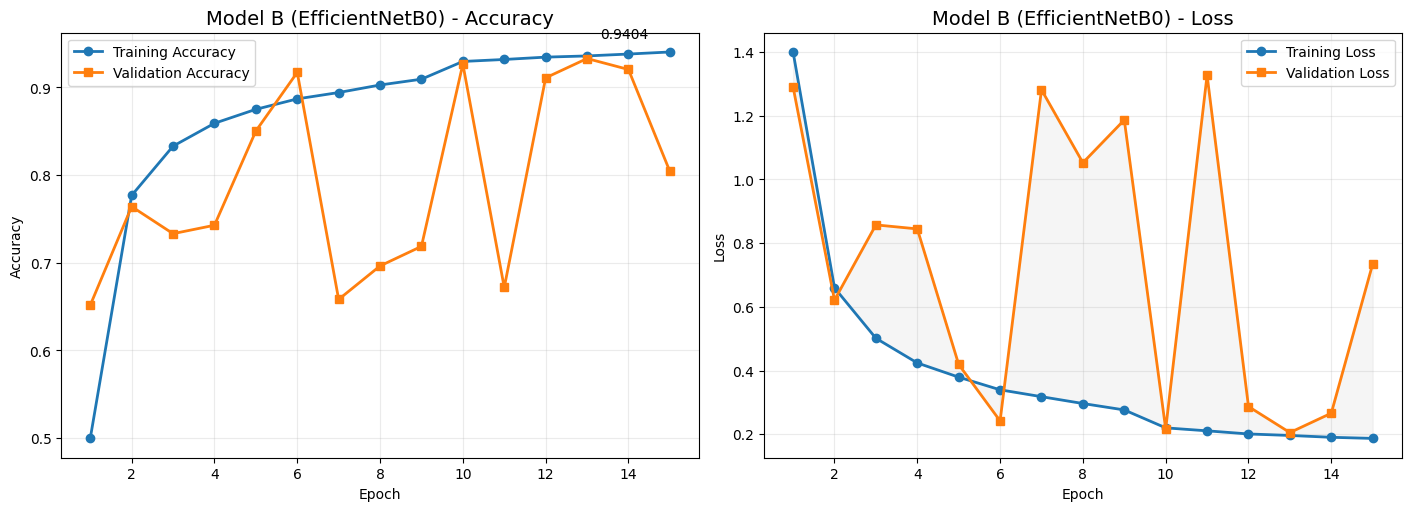

In [ ]:
plot_training_history(historyB, title_prefix="Model B (EfficientNetB0)")

8. Evaluasi Model B dengan Tulisan Tangan

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Akurasi Model B terhadap tulisan tangan: 66.67%



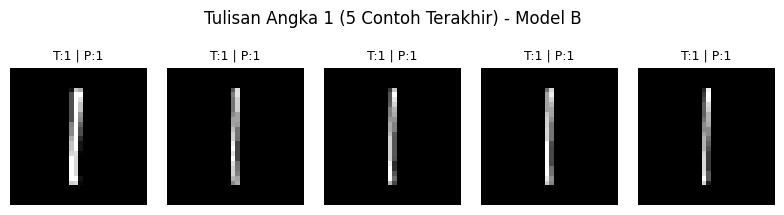

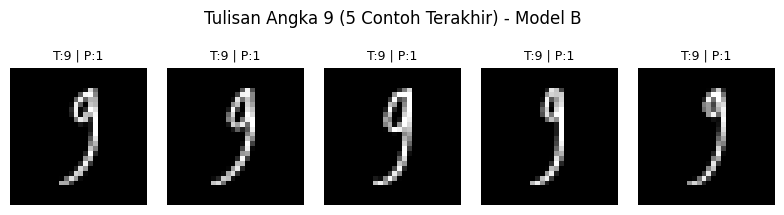

In [ ]:

if len(images) == 0:
    print("Folder tulisan tangan kosong atau tidak sesuai format.")
else:
    # convert and resize images to modelB input
    images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(images))
    images_rgb = tf.image.resize(images_rgb, [IMG_SIZE, IMG_SIZE])
    pred_B = np.argmax(modelB.predict(images_rgb), axis=1)
    acc_B = np.mean(pred_B == labels)
    print(f"Akurasi Model B terhadap tulisan tangan: {acc_B*100:.2f}%\n")

    unique_digits = sorted(list(set(labels)))
    sample_size = 5
    for digit in unique_digits:
        idxs = np.where(labels == digit)[0]
        if len(idxs) == 0: continue
        selected = idxs[-sample_size:] if len(idxs) >= sample_size else idxs
        plt.figure(figsize=(8,2))
        plt.suptitle(f"Tulisan Angka {digit} (5 Contoh Terakhir) - Model B", y=1.05)
        for i, idx in enumerate(selected):
            plt.subplot(1, len(selected), i+1)
            plt.imshow(images[idx].reshape(28,28), cmap='gray')
            plt.title(f"T:{labels[idx]} | P:{pred_B[idx]}", fontsize=9)
            plt.axis('off')
        plt.tight_layout()
        plt.show()


9. Confusion matrix pada 30 sampel

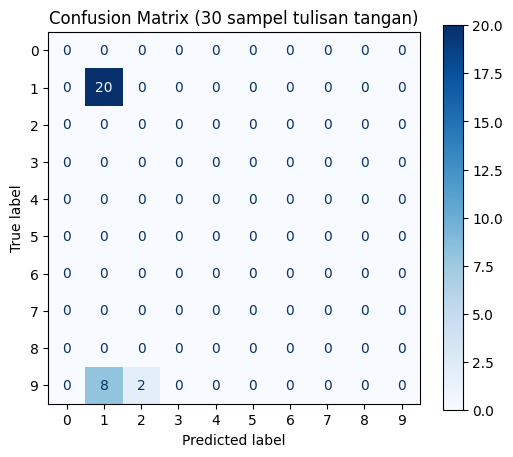

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if len(images) > 0:
    cm = confusion_matrix(labels, pred_B, labels=list(range(10)))
    disp = ConfusionMatrixDisplay(cm, display_labels=list(range(10)))
    plt.figure(figsize=(6,5))
    disp.plot(cmap='Blues', ax=plt.gca(), colorbar=True)
    plt.title("Confusion Matrix (30 sampel tulisan tangan)")
    plt.show()


10.Analisis Perbandingan Model A dan Model B

In [ ]:
# Analisis otomatis berdasarkan nilai akurasi
print("=== Analisis Perbandingan Model A dan Model B ===\n")

print(f"Akurasi Model A pada tulisan tangan : {acc_A*100:.2f}%")
print(f"Akurasi Model B pada tulisan tangan : {acc_B*100:.2f}%\n")

if acc_B > acc_A:
    print("Model B (Transfer Learning - EfficientNet) memiliki akurasi lebih tinggi dibandingkan Model A.")
    print("Hal ini menunjukkan bahwa fitur yang ditransfer dari model pra-latih (ImageNet) lebih efektif")
    print("dalam mengenali pola digit tulisan tangan dibandingkan CNN yang dibangun dari nol.")
    print("Model B dapat mengenali variasi bentuk tulisan dengan lebih stabil, meskipun data uji berasal dari tulisan pribadi.")
elif acc_B < acc_A:
    print("Model A (CNN dari nol) justru menunjukkan performa lebih baik.")
    print("Kemungkinan besar karena data MNIST yang digunakan untuk pelatihan memiliki karakteristik serupa")
    print("dengan tulisan tangan pengguna, sehingga model sederhana dapat mempelajari pola lokal dengan efisien.")
    print("Model B mungkin mengalami sedikit penurunan karena proses fine-tuning belum optimal.")
else:
    print("Kedua model memiliki akurasi yang hampir identik.")
    print("Artinya baik CNN sederhana maupun model transfer learning sama-sama mampu")
    print("menggeneralisasi dengan baik terhadap tulisan tangan pengguna.")

print("\nAnalisis tambahan:")
print("- Model A lebih ringan, cepat dilatih, dan mudah dioptimasi untuk dataset kecil seperti MNIST.")
print("- Model B lebih kompleks, tetapi unggul jika dilakukan fine-tuning lebih mendalam atau menggunakan dataset tulisan tangan yang lebih bervariasi.")
print("- Kesalahan umum terjadi pada digit mirip seperti 1 dan 9, karena bentuk tulisan yang terlalu sempit atau tidak tertutup penuh.")


=== Analisis Perbandingan Model A dan Model B ===

Akurasi Model A pada tulisan tangan : 96.67%
Akurasi Model B pada tulisan tangan : 66.67%

Model A (CNN dari nol) justru menunjukkan performa lebih baik.
Kemungkinan besar karena data MNIST yang digunakan untuk pelatihan memiliki karakteristik serupa
dengan tulisan tangan pengguna, sehingga model sederhana dapat mempelajari pola lokal dengan efisien.
Model B mungkin mengalami sedikit penurunan karena proses fine-tuning belum optimal.

Analisis tambahan:
- Model A lebih ringan, cepat dilatih, dan mudah dioptimasi untuk dataset kecil seperti MNIST.
- Model B lebih kompleks, tetapi unggul jika dilakukan fine-tuning lebih mendalam atau menggunakan dataset tulisan tangan yang lebih bervariasi.
- Kesalahan umum terjadi pada digit mirip seperti 1 dan 9, karena bentuk tulisan yang terlalu sempit atau tidak tertutup penuh.


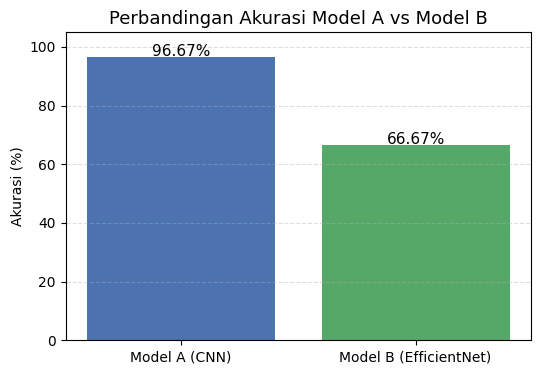

In [ ]:
#Visualisasi Perbandingan Akurasi Model

models = ['Model A (CNN)', 'Model B (EfficientNet)']
accuracies = [acc_A * 100, acc_B * 100]

plt.figure(figsize=(6,4))
bars = plt.bar(models, accuracies, color=['#4C72B0', '#55A868'])
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.2, f"{acc:.2f}%", ha='center', fontsize=11)
plt.title("Perbandingan Akurasi Model A vs Model B", fontsize=13)
plt.ylabel("Akurasi (%)")
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


coba